In [91]:
import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns


In [93]:
data_tree = pd.read_csv("p2-arbres-fr.csv", sep=";")
#data_tree.head(5)

In [94]:
data_tree.shape

(200137, 18)

In [95]:
data_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   200137 non-null  int64  
 1   type_emplacement     200137 non-null  object 
 2   domanialite          200136 non-null  object 
 3   arrondissement       200137 non-null  object 
 4   complement_addresse  30902 non-null   object 
 5   numero               0 non-null       float64
 6   lieu                 200137 non-null  object 
 7   id_emplacement       200137 non-null  object 
 8   libelle_francais     198640 non-null  object 
 9   genre                200121 non-null  object 
 10  espece               198385 non-null  object 
 11  variete              36777 non-null   object 
 12  circonference_cm     200137 non-null  int64  
 13  hauteur_m            200137 non-null  int64  
 14  stade_developpement  132932 non-null  object 
 15  remarquable      

In [96]:
data_tree.dtypes

id                       int64
type_emplacement        object
domanialite             object
arrondissement          object
complement_addresse     object
numero                 float64
lieu                    object
id_emplacement          object
libelle_francais        object
genre                   object
espece                  object
variete                 object
circonference_cm         int64
hauteur_m                int64
stade_developpement     object
remarquable            float64
geo_point_2d_a         float64
geo_point_2d_b         float64
dtype: object

In [97]:
data_tree.isna().sum()

id                          0
type_emplacement            0
domanialite                 1
arrondissement              0
complement_addresse    169235
numero                 200137
lieu                        0
id_emplacement              0
libelle_francais         1497
genre                      16
espece                   1752
variete                163360
circonference_cm            0
hauteur_m                   0
stade_developpement     67205
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

<AxesSubplot:>

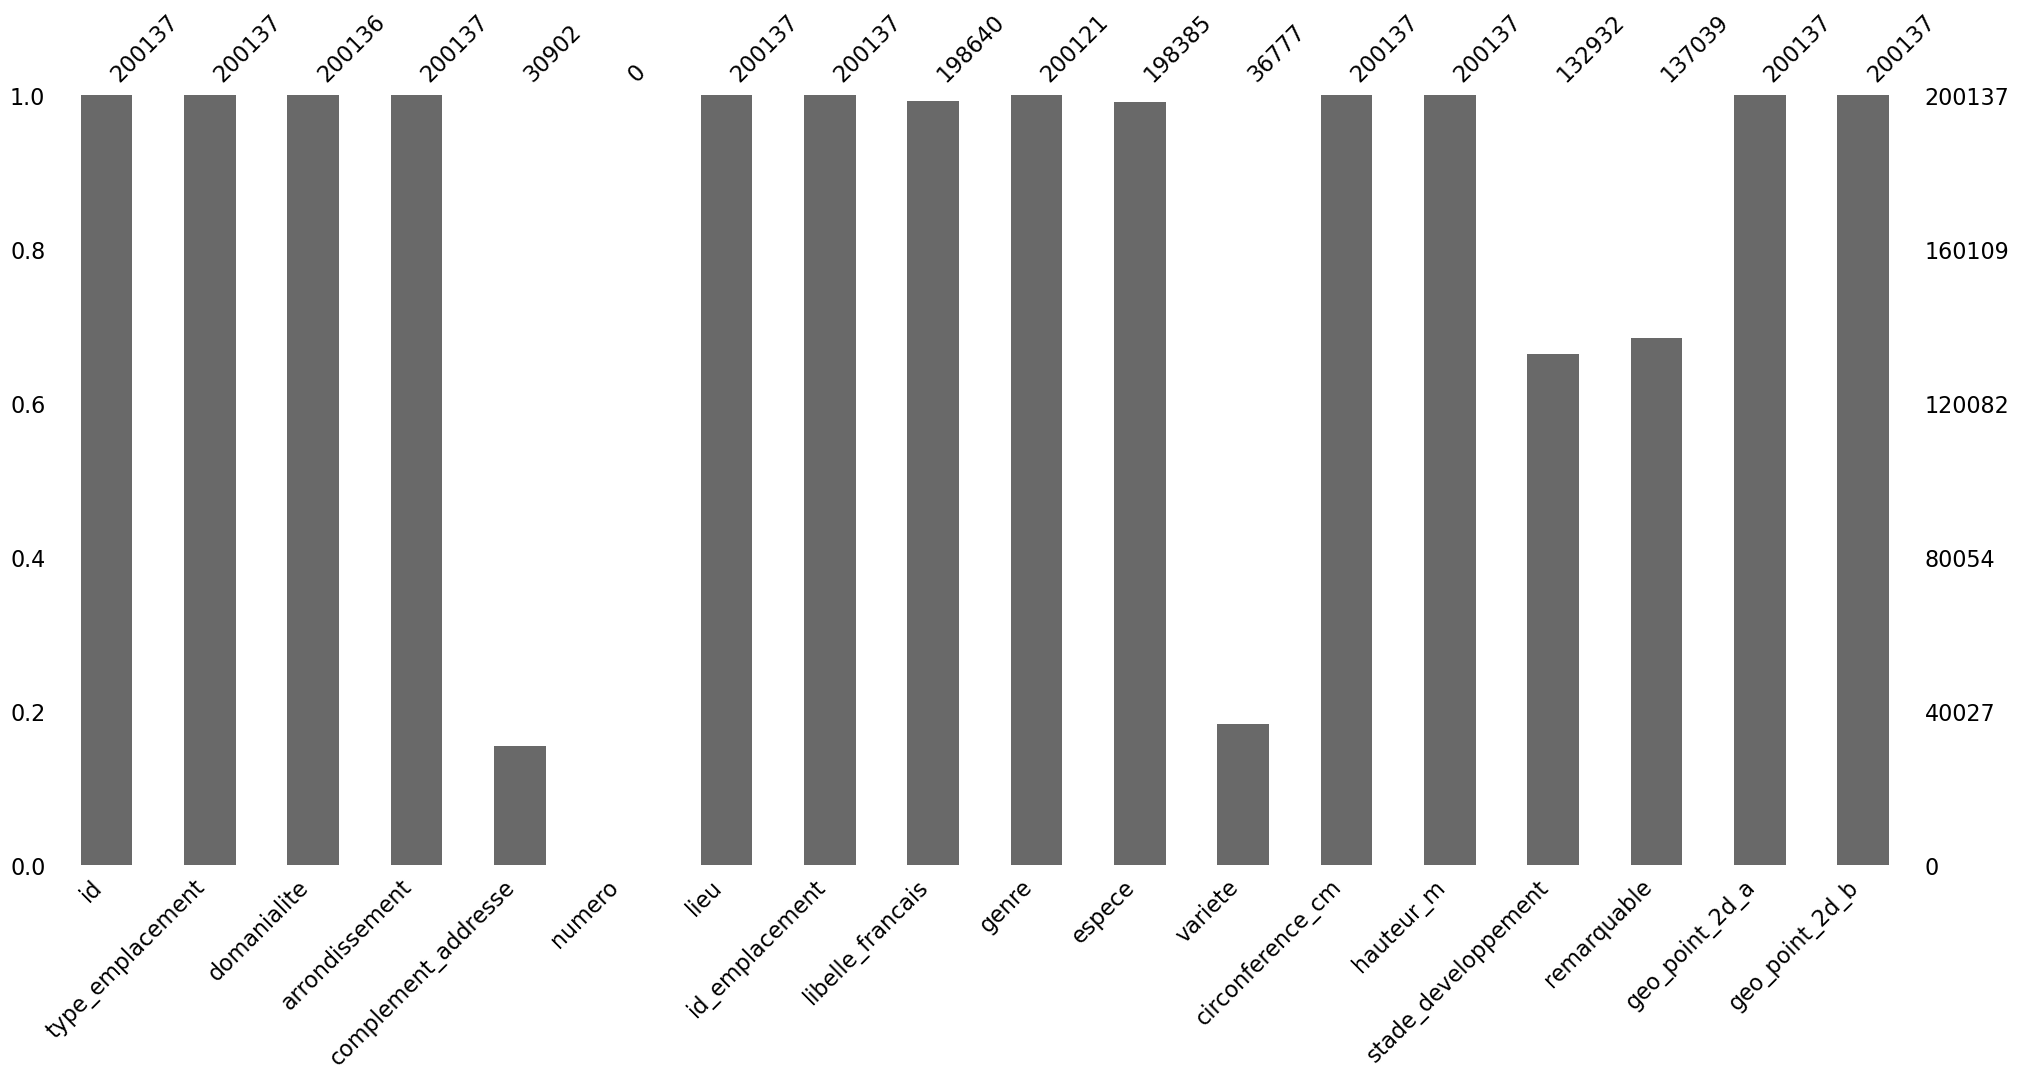

In [98]:
msno.bar(data_tree)

In [31]:
data_tree.drop(["id","numero"], axis =1, inplace= True)

In [32]:
data_tree.columns

Index(['type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'lieu', 'id_emplacement', 'libelle_francais',
       'genre', 'espece', 'variete', 'circonference_cm', 'hauteur_m',
       'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b'],
      dtype='object')

In [36]:
data_tree.describe()

,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
count,200137.000000,200137.000000,137039.000000,200137.000000,200137.000000
mean,83.380479,13.110509,0.001343,48.854491,2.348208
std,673.190213,1971.217387,0.036618,0.030234,0.051220
min,0.000000,0.000000,0.000000,48.742290,2.210241
25%,30.000000,5.000000,0.000000,48.835021,2.307530
50%,70.000000,8.000000,0.000000,48.854162,2.351095
75%,115.000000,12.000000,0.000000,48.876447,2.386838
max,250255.000000,881818.000000,1.000000,48.911485,2.469759


In [35]:
data_tree.describe(include=[object])

,type_emplacement,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,variete,stade_developpement
count,200137,200136,200137,30902,200137,200137,198640,200121,198385,36777,132932
unique,1,9,25,3795,6921,69040,192,175,539,436,4
top,Arbre,Alignement,PARIS 15E ARRDT,SN°,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,101001,Platane,Platanus,x hispanica,Baumannii',A
freq,200137,104949,17151,557,2995,1324,42508,42591,36409,4538,64438


In [37]:
data_tree.corr()

,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
circonference_cm,1.000000,0.000413,0.009480,0.008704,-0.004617
hauteur_m,0.000413,1.000000,0.000070,-0.002167,0.004631
remarquable,0.009480,0.000070,1.000000,0.003465,-0.011759
geo_point_2d_a,0.008704,-0.002167,0.003465,1.000000,-0.010613
geo_point_2d_b,-0.004617,0.004631,-0.011759,-0.010613,1.000000


In [38]:
data_tree.columns

Index(['type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'lieu', 'id_emplacement', 'libelle_francais',
       'genre', 'espece', 'variete', 'circonference_cm', 'hauteur_m',
       'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b'],
      dtype='object')

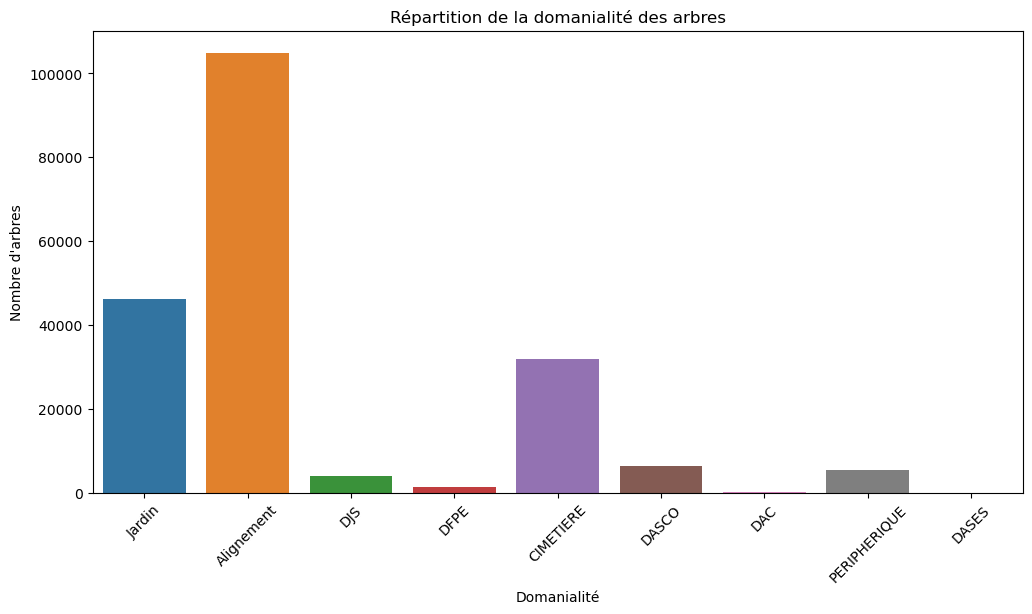

In [41]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data_tree, x='domanialite')
plt.title('Répartition de la domanialité des arbres')
plt.xlabel('Domanialité')
plt.ylabel('Nombre d\'arbres')
plt.xticks(rotation=45)
plt.show()

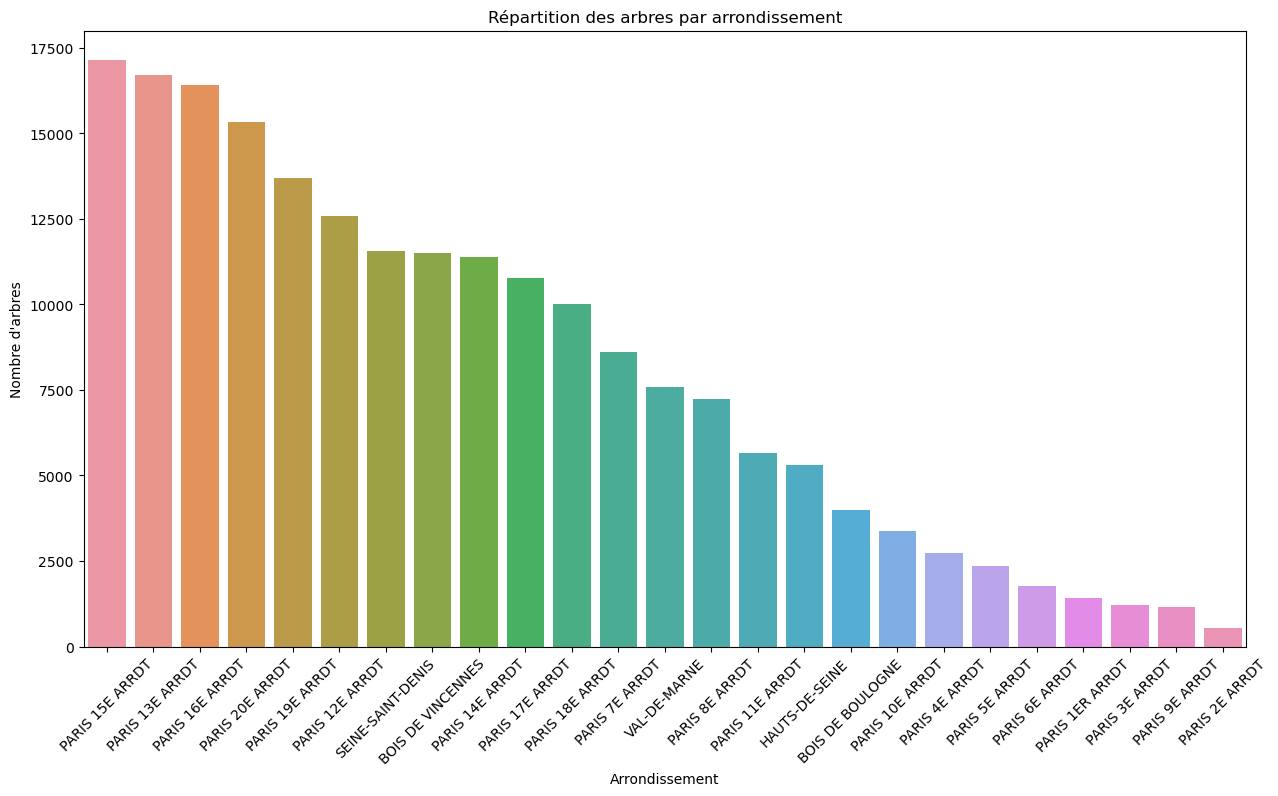

In [44]:
plt.figure(figsize=(15, 8))
sns.countplot(data=data_tree, x='arrondissement', order=data_tree['arrondissement'].value_counts().index)
plt.title('Répartition des arbres par arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Nombre d\'arbres')
plt.xticks(rotation=45)
plt.show()

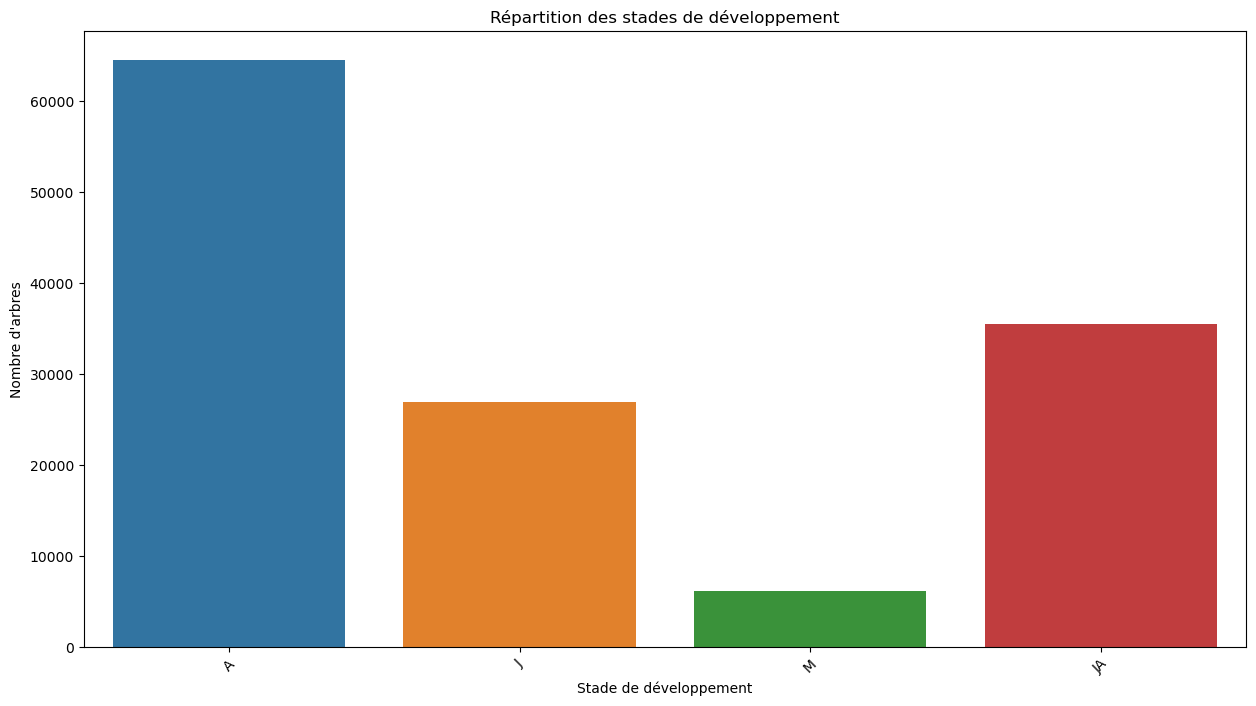

In [51]:
plt.figure(figsize=(15, 8))
sns.countplot(data=data_tree, x='stade_developpement')
plt.title('Répartition des stades de développement')
plt.xlabel('Stade de développement')
plt.ylabel('Nombre d\'arbres')
plt.xticks(rotation=45)
plt.show()

In [52]:
data_tree.arrondissement.value_counts()

PARIS 15E ARRDT      17151
PARIS 13E ARRDT      16712
PARIS 16E ARRDT      16403
PARIS 20E ARRDT      15340
PARIS 19E ARRDT      13709
PARIS 12E ARRDT      12600
SEINE-SAINT-DENIS    11570
BOIS DE VINCENNES    11510
PARIS 14E ARRDT      11399
PARIS 17E ARRDT      10762
PARIS 18E ARRDT      10011
PARIS 7E ARRDT        8617
VAL-DE-MARNE          7580
PARIS 8E ARRDT        7245
PARIS 11E ARRDT       5658
HAUTS-DE-SEINE        5298
BOIS DE BOULOGNE      3978
PARIS 10E ARRDT       3385
PARIS 4E ARRDT        2740
PARIS 5E ARRDT        2368
PARIS 6E ARRDT        1764
PARIS 1ER ARRDT       1413
PARIS 3E ARRDT        1209
PARIS 9E ARRDT        1167
PARIS 2E ARRDT         548
Name: arrondissement, dtype: int64

In [57]:
data_tree.isna().sum()/ 200137

type_emplacement       0.000000
domanialite            0.000005
arrondissement         0.000000
complement_addresse    0.845596
lieu                   0.000000
id_emplacement         0.000000
libelle_francais       0.007480
genre                  0.000080
espece                 0.008754
variete                0.816241
circonference_cm       0.000000
hauteur_m              0.000000
stade_developpement    0.335795
remarquable            0.315274
geo_point_2d_a         0.000000
geo_point_2d_b         0.000000
dtype: float64

In [60]:
### suppression des colonnes complement_adresse et lieu, variété
### colonne genre et espèces suppression des lignes manquantes
### colonne variete pas importante
### Impute colonnes stade_developpement, remarquable

In [83]:
data_tree.drop(["complement_addresse","lieu"], axis =1, inplace= True)

KeyError: "['complement_addresse', 'lieu'] not found in axis"

In [84]:
data_tree.drop('variete', axis=1, inplace=True)

In [87]:
df = data_tree.copy()



In [81]:
df.dropna(subset = ['genre', 'espece'], inplace=True)

In [88]:
cols_stade_remarquable = df[['stade_developpement','remarquable']]


In [89]:
for col in cols_stade_remarquable  :
    df[col].fillna(df[col].mode()[0], inplace=True)

In [90]:
df.isna().sum()

type_emplacement          0
domanialite               1
arrondissement            0
id_emplacement            0
libelle_francais       1497
genre                    16
espece                 1752
circonference_cm          0
hauteur_m                 0
stade_developpement       0
remarquable               0
geo_point_2d_a            0
geo_point_2d_b            0
dtype: int64